In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [2]:
path = 'https://docs.google.com/spreadsheets/d/1wrgQMRB4cz1byh66hrBP0PgDGbTWNxTKPVossrwQfQs/pub?gid=890227267&single=true&output=csv'
df = pd.read_csv(path)

In [3]:
df.shape

(50000, 2)

In [4]:
sentences = df['review'].values
labels = df['sentiment'].map({'negative':0, 'positive':1})

In [5]:
# Tokenization des phrases, en limitant à 5000 mots
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [6]:
# Padding des séquences pour qu'elles aient toutes la même longueur (200)
maxlen = 200
X = pad_sequences(sequences, maxlen=maxlen)
y = np.array(labels)

In [7]:
# Division des données en ensembles d'entraînement et de test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Construction du modèle RNN
model = Sequential([
    Embedding(input_dim=5000, output_dim=128),  # Couche d'embedding
    SimpleRNN(64, return_sequences=False, kernel_regularizer=regularizers.l2(0.01)),  # RNN simple avec régularisation L2
    Dropout(0.7),  # Dropout pour éviter le surapprentissage
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Couche dense avec régularisation L2
    Dropout(0.7),  # Dropout supplémentaire
    Dense(1, activation='sigmoid')  # Couche de sortie pour la classification binaire
])

In [9]:
# Compilation du modèle avec l'optimiseur Adam et la fonction de perte binaire
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# Définition du callback pour un arrêt anticipé (early stopping)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [11]:
# Entraînement du modèle avec validation sur l'ensemble de test
history = model.fit(X_train, y_train,
                    epochs=20, batch_size=128,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/20
313/313 [==============================] - 20s 58ms/step - loss: 1.7977 - accuracy: 0.5020 - val_loss: 1.6017 - val_accuracy: 0.5202
Epoch 2/20
313/313 [==============================] - 18s 59ms/step - loss: 1.4665 - accuracy: 0.5078 - val_loss: 1.3248 - val_accuracy: 0.5680
Epoch 3/20
313/313 [==============================] - 19s 59ms/step - loss: 1.2053 - accuracy: 0.5694 - val_loss: 1.0450 - val_accuracy: 0.7536
Epoch 4/20
313/313 [==============================] - 18s 58ms/step - loss: 0.9959 - accuracy: 0.7033 - val_loss: 0.9257 - val_accuracy: 0.7005
Epoch 5/20
313/313 [==============================] - 18s 59ms/step - loss: 0.8236 - accuracy: 0.7896 - val_loss: 0.6963 - val_accuracy: 0.8328
Epoch 6/20
313/313 [==============================] - 19s 60ms/step - loss: 0.6780 - accuracy: 0.8501 - val_loss: 0.6002 - val_accuracy: 0.8486
Epoch 7/20
313/313 [==============================] - 18s 59ms/step - loss: 0.5842 - accuracy: 0.8748 - val_loss: 0.5227 - val_accuracy:

In [12]:
# Évaluation du modèle sur l'ensemble de test
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

313/313 [==============================] - 4s 12ms/step - loss: 0.3674 - accuracy: 0.8776
Test Accuracy: 0.8776


In [13]:
# Prédiction et évaluation de l'exactitude du modèle
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(f'Accuracy Score: {accuracy_score(y_test, y_pred):.4f}')

313/313 [==============================] - 4s 11ms/step
Accuracy Score: 0.8776


<Axes: >

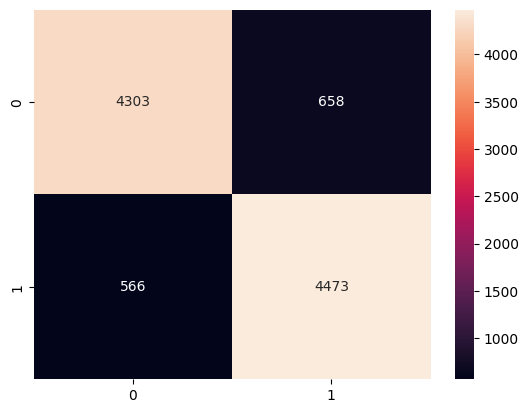

In [14]:
# Matrice de confusion pour visualiser les performances du modèle
conf_m = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_m, annot=True, fmt='g')